# Improved Traffic Sign Recognition with Hybrid CNN-Tsetlin Machine

This notebook implements an improved hybrid approach for traffic sign recognition using:
1. Adaptive Gaussian thresholding for preprocessing
2. A simplified CNN for feature extraction
3. Tsetlin Machine for classification of extracted features

## 1. Import Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for the CNN feature extractor
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Tsetlin Machine for classification
from tmu.models.classification.vanilla_classifier import TMClassifier

2025-03-15 20:29:14,834 - tmu.util.cuda_profiler - WARNING - Could not import pycuda: No module named 'pycuda'
2025-03-15 20:29:14,836 - tmu.clause_bank.clause_bank_cuda - ERROR - No module named 'pycuda'
Traceback (most recent call last):
  File "c:\Users\ahpuh\AppData\Local\Programs\Python\Python310\lib\site-packages\tmu\clause_bank\clause_bank_cuda.py", line 41, in <module>
    from pycuda._driver import Device, Context
ModuleNotFoundError: No module named 'pycuda'
2025-03-15 20:29:14,840 - tmu.clause_bank.clause_bank_cuda - WARNING - Could not import pycuda. This indicates that it is not installed! A possible fix is to run 'pip install pycuda'. Fallback to CPU ClauseBanks.


## 2. Helper Functions

These functions help with loading data and preprocessing images using adaptive Gaussian thresholding.

In [2]:
def load_pickle_file(file_path):
    """Load pickle files containing the datasets."""
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    return data

def load_sign_names(csv_path):
    """Load mapping of class IDs to sign names from CSV."""
    df = pd.read_csv(csv_path)
    sign_mapping = dict(zip(df['ClassId'], df['SignName']))
    return sign_mapping

def preprocess_images_with_adaptive_thresholding(image):
    """Preprocess images using adaptive Gaussian thresholding method.
    
    This approach adapts the threshold based on local image regions,
    which can better handle varying lighting conditions across the image.
    """
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Apply adaptive Gaussian thresholding
    # Parameters: block size = 11, C = 2 (constant subtracted from the mean)
    binary_image = cv2.adaptiveThreshold(
        blurred, 
        1, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 
        2
    )
    return binary_image

def visualize_preprocessing(original_image, preprocessed_image, ax=None):
    """Visualize the original and preprocessed images side by side."""
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot original image
    if len(original_image.shape) == 3 and original_image.shape[2] == 3:
        ax[0].imshow(original_image)
    else:
        ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Plot preprocessed image
    ax[1].imshow(preprocessed_image, cmap='gray')
    ax[1].set_title('Preprocessed Image')
    ax[1].axis('off')

    return ax

## 3. Load and Prepare Data

Load the traffic sign data from pickle files and the sign name mapping.

In [3]:
# Update these paths to match your local file locations
sign_mapping = load_sign_names('C:/Users/ahpuh/Desktop/Improved_Tsetlin_Machine/signname.csv')
train_data = load_pickle_file('C:/Users/ahpuh/Desktop/Improved_Tsetlin_Machine/train.p')
valid_data = load_pickle_file('C:/Users/ahpuh/Desktop/Improved_Tsetlin_Machine/valid.p')
test_data = load_pickle_file('C:/Users/ahpuh/Desktop/Improved_Tsetlin_Machine/test.p')

X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

# Determine the number of classes for the classifier
num_classes = len(np.unique(y_train))

# Display data summary
print(f"Training set: {X_train.shape} images, {y_train.shape} labels")
print(f"Validation set: {X_valid.shape} images, {y_valid.shape} labels")
print(f"Test set: {X_test.shape} images, {y_test.shape} labels")
print(f"Number of unique classes: {num_classes}")

Training set: (34799, 32, 32, 3) images, (34799,) labels
Validation set: (4410, 32, 32, 3) images, (4410,) labels
Test set: (12630, 32, 32, 3) images, (12630,) labels
Number of unique classes: 43


## 4. Preprocess Data using Adaptive Gaussian Thresholding

Apply adaptive Gaussian thresholding to preprocess the images.

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...
Processed data shapes: (34799, 32, 32), (4410, 32, 32), (12630, 32, 32)


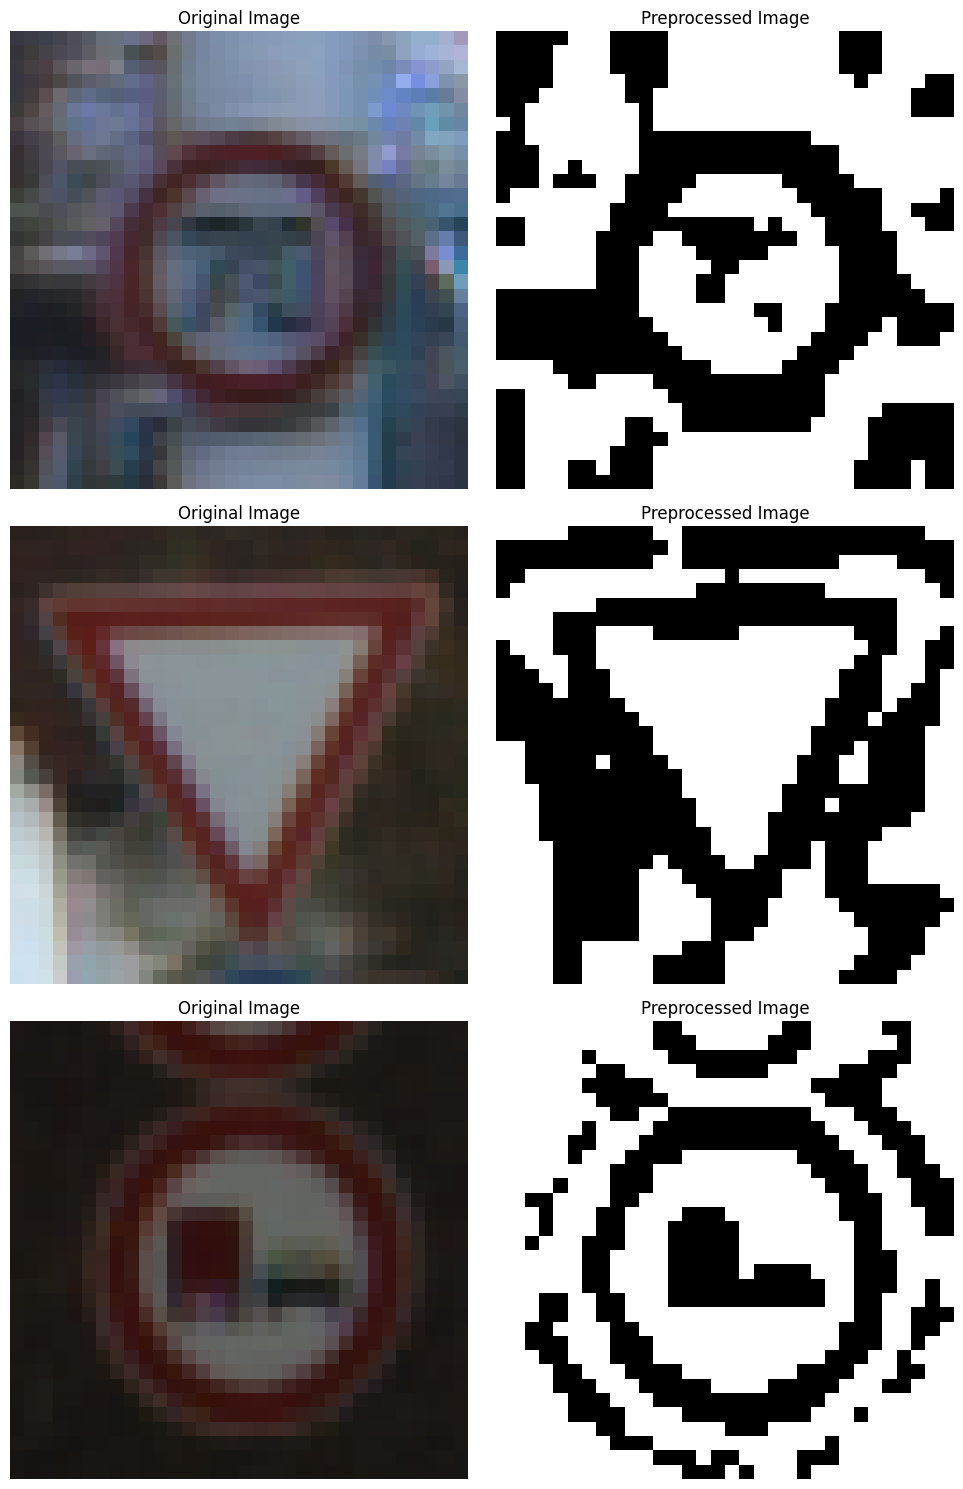

In [4]:
# Preprocess all datasets
print("Preprocessing training data...")
X_train_binary = np.array([preprocess_images_with_adaptive_thresholding(img) for img in X_train])

print("Preprocessing validation data...")
X_valid_binary = np.array([preprocess_images_with_adaptive_thresholding(img) for img in X_valid])

print("Preprocessing test data...")
X_test_binary = np.array([preprocess_images_with_adaptive_thresholding(img) for img in X_test])

# Display preprocessed shapes
print(f"Processed data shapes: {X_train_binary.shape}, {X_valid_binary.shape}, {X_test_binary.shape}")

# Visualize a few examples of the preprocessing
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    idx = np.random.randint(0, len(X_train))
    visualize_preprocessing(X_train[idx], X_train_binary[idx], axes[i])

plt.tight_layout()
plt.show()

## 5. Simplified CNN Architecture for Feature Extraction

Design a simplified CNN architecture for feature extraction.

In [5]:
def build_feature_extractor():
    """Build a simpler CNN feature extractor with a single convolutional block."""
    inputs = Input(shape=(32, 32, 1))
    
    # Single convolutional block with fewer filters
    x = Conv2D(12, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    # Output feature map size: 16x16x12
    model = Model(inputs=inputs, outputs=x, name="simple_cnn_feature_extractor")
    return model

# Create and display the simplified architecture
feature_extractor = build_feature_extractor()
feature_extractor.summary()

# Prepare data for the CNN (add channel dimension)
X_train_cnn = X_train_binary.reshape(-1, 32, 32, 1)
X_valid_cnn = X_valid_binary.reshape(-1, 32, 32, 1)
X_test_cnn = X_test_binary.reshape(-1, 32, 32, 1)

Model: "simple_cnn_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 12)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 12)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120 (480.00 B)

 Trainable params: 120 (480.00 B)

 Non-trainable params: 0 (0.00 B)

## 6. Pre-training the CNN Feature Extractor

Pre-train the CNN feature extractor on the classification task to learn useful features.

Pre-training the CNN feature extractor...
Epoch 1/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2874 - loss: 2.7287 - val_accuracy: 0.6925 - val_loss: 1.1790
Epoch 2/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6419 - loss: 1.1969 - val_accuracy: 0.7594 - val_loss: 0.8181
Epoch 3/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7176 - loss: 0.8947 - val_accuracy: 0.7971 - val_loss: 0.6848
Epoch 4/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7516 - loss: 0.7724 - val_accuracy: 0.8016 - val_loss: 0.6388
Epoch 5/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7703 - loss: 0.7196 - val_accuracy: 0.8111 - val_loss: 0.6424
Epoch 6/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7868 - loss: 0.6486 - val_accuracy: 0.8263 - val_loss: 0.5896
Epoch 7/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8013 - loss: 0.6108 - val_accuracy: 0.8252 - val_loss: 0.5938
Epoch 8/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy

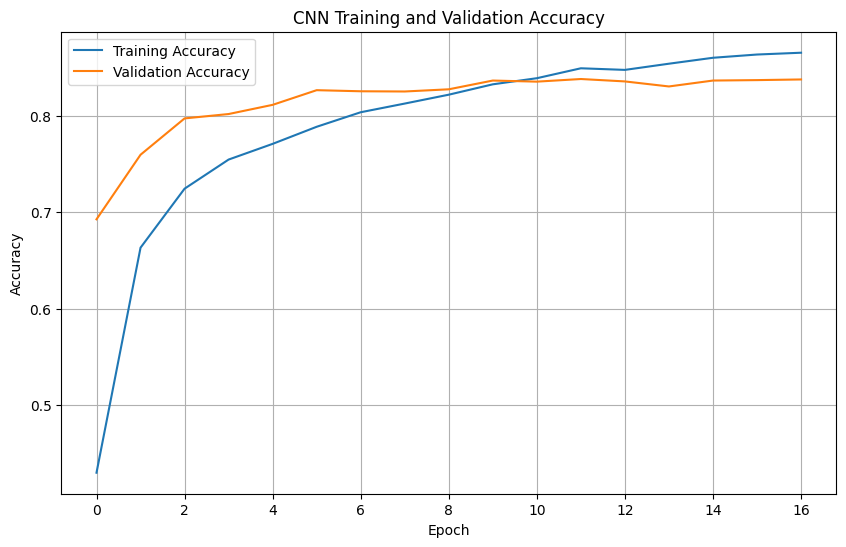

In [6]:
# Create a full CNN model for pre-training (feature extractor + classifier head)
def build_cnn_classifier(feature_extractor):
    """Build a complete CNN classifier using the feature extractor"""
    model = Sequential([
        feature_extractor,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create the complete CNN classifier
cnn_classifier = build_cnn_classifier(feature_extractor)
cnn_classifier.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Train the CNN
print("Pre-training the CNN feature extractor...")
history = cnn_classifier.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_valid_cnn, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate CNN performance
cnn_valid_acc = cnn_classifier.evaluate(X_valid_cnn, y_valid)[1] * 100
print(f"CNN Validation Accuracy: {cnn_valid_acc:.2f}%")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 7. Extract Features using the Pre-trained CNN

Extract features from all datasets using the pre-trained feature extractor.

Extracting features from training data...
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step
Extracting features from validation data...
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
Extracting features from test data...
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
Feature shapes: (34799, 3072), (4410, 3072), (12630, 3072)


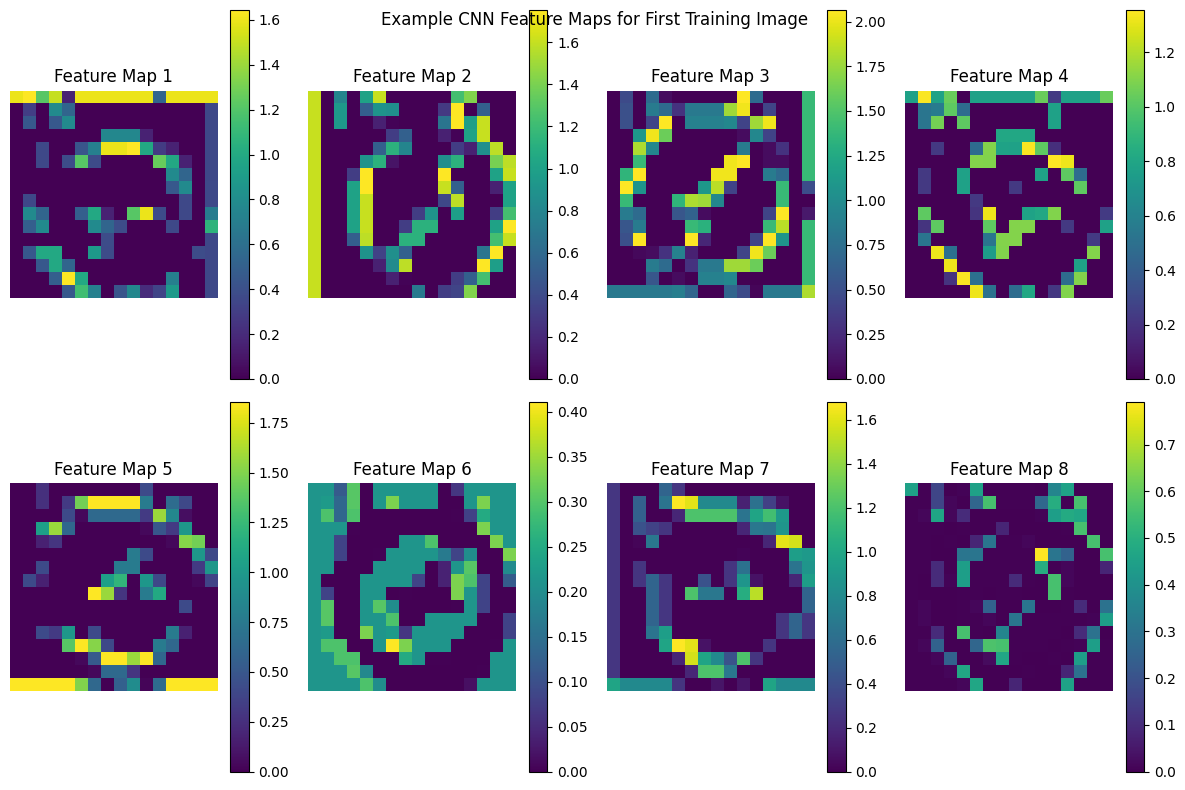

In [7]:
# Extract features from all datasets
print("Extracting features from training data...")
X_train_features = feature_extractor.predict(X_train_cnn)
print("Extracting features from validation data...")
X_valid_features = feature_extractor.predict(X_valid_cnn)
print("Extracting features from test data...")
X_test_features = feature_extractor.predict(X_test_cnn)

# Flatten and binarize the features for the Tsetlin Machine
# We threshold at 0 since ReLU activation produces positive values
threshold = 0.1

X_train_features_flat = (X_train_features.reshape(X_train_features.shape[0], -1) > threshold).astype(np.uint32)
X_valid_features_flat = (X_valid_features.reshape(X_valid_features.shape[0], -1) > threshold).astype(np.uint32)
X_test_features_flat = (X_test_features.reshape(X_test_features.shape[0], -1) > threshold).astype(np.uint32)

print(f"Feature shapes: {X_train_features_flat.shape}, {X_valid_features_flat.shape}, {X_test_features_flat.shape}")

# Visualize some extracted features
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train_features[0, :, :, i], cmap='viridis')
    plt.title(f'Feature Map {i+1}')
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Example CNN Feature Maps for First Training Image')
plt.show()

## 8. Configure and Train the Tsetlin Machine

Configure and train the Tsetlin Machine on the extracted CNN features.

In [8]:
# Convert labels to uint32 for Tsetlin Machine compatibility
y_train_tm = y_train.astype(np.uint32)
y_valid_tm = y_valid.astype(np.uint32)
y_test_tm = y_test.astype(np.uint32)

# Configure Tsetlin Machine with optimized parameters
# Use more clauses since we're working with CNN-extracted features
num_features = X_train_features_flat.shape[1]
num_clauses = 200  # More clauses for better representational capacity

# Improved T and s parameter calculation for better accuracy
# T controls threshold for including literals (higher = more conservative)
# s controls specificity (influences Type I vs Type II feedback balance)
T = max(15, int(num_clauses * 0.15))  # Scale T with clause count, minimum of 15
s = 3.0  # Lower s value (compared to default) for more aggressive learning

# Alternative configurations to try (uncomment to experiment)
# Configuration 1: More conservative
# T = max(20, int(num_clauses * 0.2))
# s = 2.5

# Configuration 2: More balanced
# T = max(10, int(num_clauses * 0.1))
# s = 3.9

# Create the Tsetlin Machine classifier
hybrid_tm = TMClassifier(
    number_of_clauses=num_clauses,
    T=T,
    s=s,
    clause_drop_p=0.05,  # Small dropout for regularization
    weighted_clauses=True  # Use weighted clauses for better performance
)

print(f"Tsetlin Machine configured with:")
print(f"- {hybrid_tm.number_of_clauses} clauses")
print(f"- T={hybrid_tm.T}, s={hybrid_tm.s}, drop_p={hybrid_tm.clause_drop_p}")
print(f"- Working with {num_features} features")

# Train the Tsetlin Machine with early stopping
print("\nTraining Hybrid CNN-Tsetlin Machine...")
best_val_acc = 0.0
patience = 20
patience_counter = 0
best_epoch = 0

# Track metrics for plotting
hybrid_train_accuracies = []
hybrid_valid_accuracies = []

for epoch in range(100):  # Fewer epochs needed when using pre-extracted features
    # Train for multiple epochs per iteration
    hybrid_tm.fit(X_train_features_flat, y_train_tm, epochs=2)
    
    train_pred = hybrid_tm.predict(X_train_features_flat)
    valid_pred = hybrid_tm.predict(X_valid_features_flat)
    
    train_acc = accuracy_score(y_train_tm, train_pred) * 100
    valid_acc = accuracy_score(y_valid_tm, valid_pred) * 100
    
    hybrid_train_accuracies.append(train_acc)
    hybrid_valid_accuracies.append(valid_acc)
    
    print(f"Epoch {epoch+1}/100 - Train Accuracy: {train_acc:.2f}% | Validation Accuracy: {valid_acc:.2f}%")
    
    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        best_epoch = epoch
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs.")
            break

print(f"\nBest validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch+1}")

Tsetlin Machine configured with:
- 200 clauses
- T=30, s=3.0, drop_p=0.05
- Working with 3072 features

Training Hybrid CNN-Tsetlin Machine...
Epoch 1/100 - Train Accuracy: 79.21% | Validation Accuracy: 68.84%
Epoch 2/100 - Train Accuracy: 84.42% | Validation Accuracy: 72.56%
Epoch 3/100 - Train Accuracy: 87.39% | Validation Accuracy: 75.12%
Epoch 4/100 - Train Accuracy: 88.09% | Validation Accuracy: 74.85%
Epoch 5/100 - Train Accuracy: 89.67% | Validation Accuracy: 75.92%
Epoch 6/100 - Train Accuracy: 91.01% | Validation Accuracy: 77.91%
Epoch 7/100 - Train Accuracy: 90.55% | Validation Accuracy: 77.07%
Epoch 8/100 - Train Accuracy: 91.68% | Validation Accuracy: 77.37%
Epoch 9/100 - Train Accuracy: 91.95% | Validation Accuracy: 78.84%
Epoch 10/100 - Train Accuracy: 92.67% | Validation Accuracy: 78.78%
Epoch 11/100 - Train Accuracy: 92.40% | Validation Accuracy: 77.71%
Epoch 12/100 - Train Accuracy: 93.77% | Validation Accuracy: 80.59%
Epoch 13/100 - Train Accuracy: 93.68% | Validation

## 9. Plotting Training Progress

Plot the training and validation accuracy of the hybrid model.

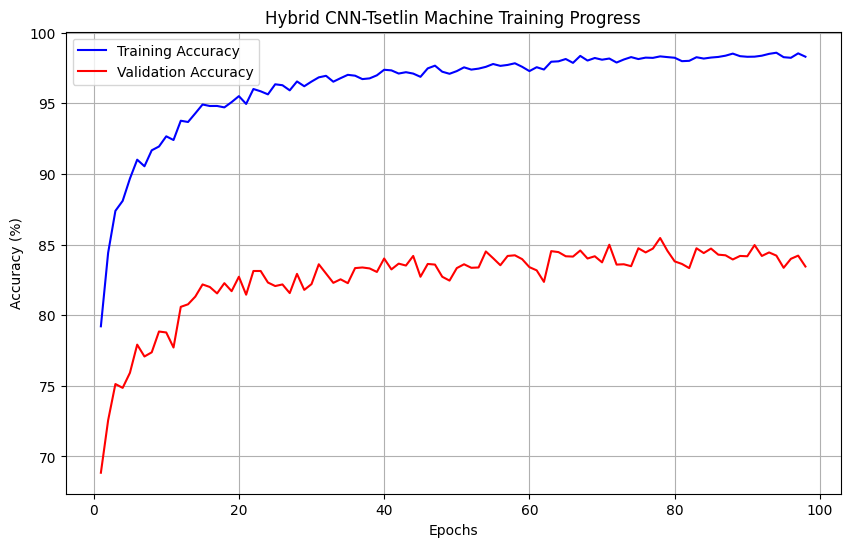

In [9]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
epochs = range(1, len(hybrid_train_accuracies) + 1)
plt.plot(epochs, hybrid_train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, hybrid_valid_accuracies, 'r-', label='Validation Accuracy')
plt.title('Hybrid CNN-Tsetlin Machine Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

## 10. Evaluate on Test Set

Evaluate the hybrid model on the test set and compare with other models.

Hybrid CNN-Tsetlin Machine Test Accuracy: 84.17%
Pure CNN Test Accuracy: 83.97%


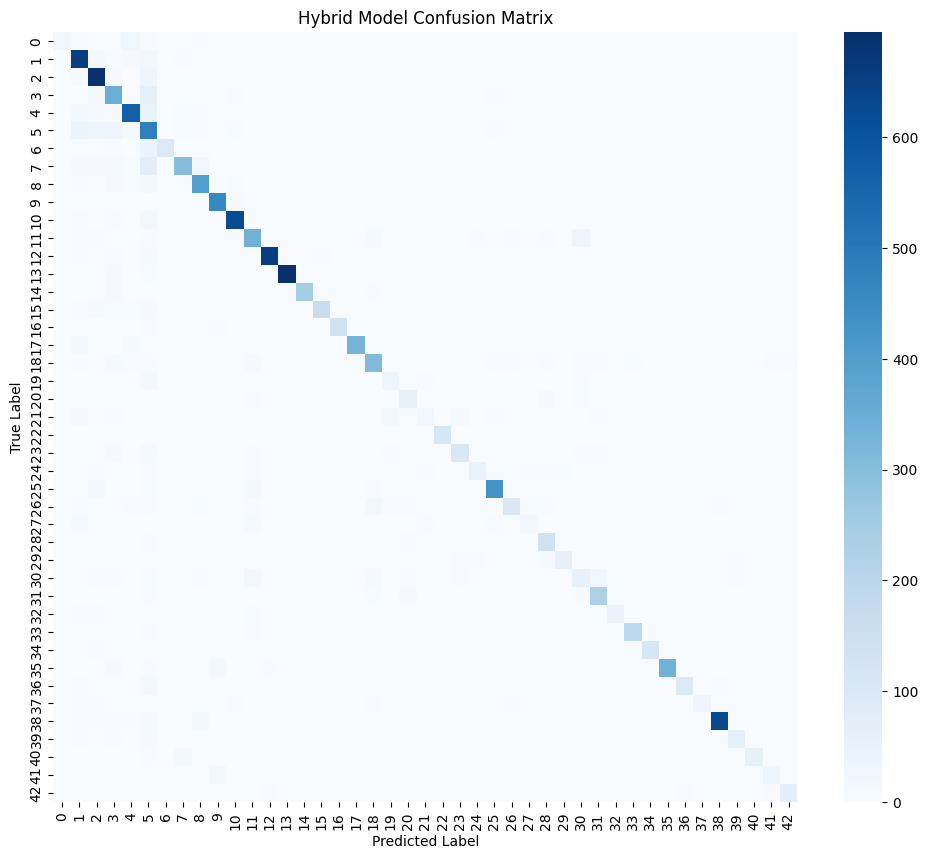

In [10]:
# Evaluate on Test Set
hybrid_test_pred = hybrid_tm.predict(X_test_features_flat)
hybrid_test_acc = accuracy_score(y_test_tm, hybrid_test_pred) * 100
print(f"Hybrid CNN-Tsetlin Machine Test Accuracy: {hybrid_test_acc:.2f}%")

# For comparison, also evaluate the full CNN model
cnn_test_acc = cnn_classifier.evaluate(X_test_cnn, y_test, verbose=0)[1] * 100
print(f"Pure CNN Test Accuracy: {cnn_test_acc:.2f}%")

# Create confusion matrix for the hybrid model
hybrid_cm = confusion_matrix(y_test_tm, hybrid_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(hybrid_cm, annot=False, fmt='d', cmap='Blues')
plt.title('Hybrid Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 11. Visualize Test Predictions

Visualize random test samples with their predictions.

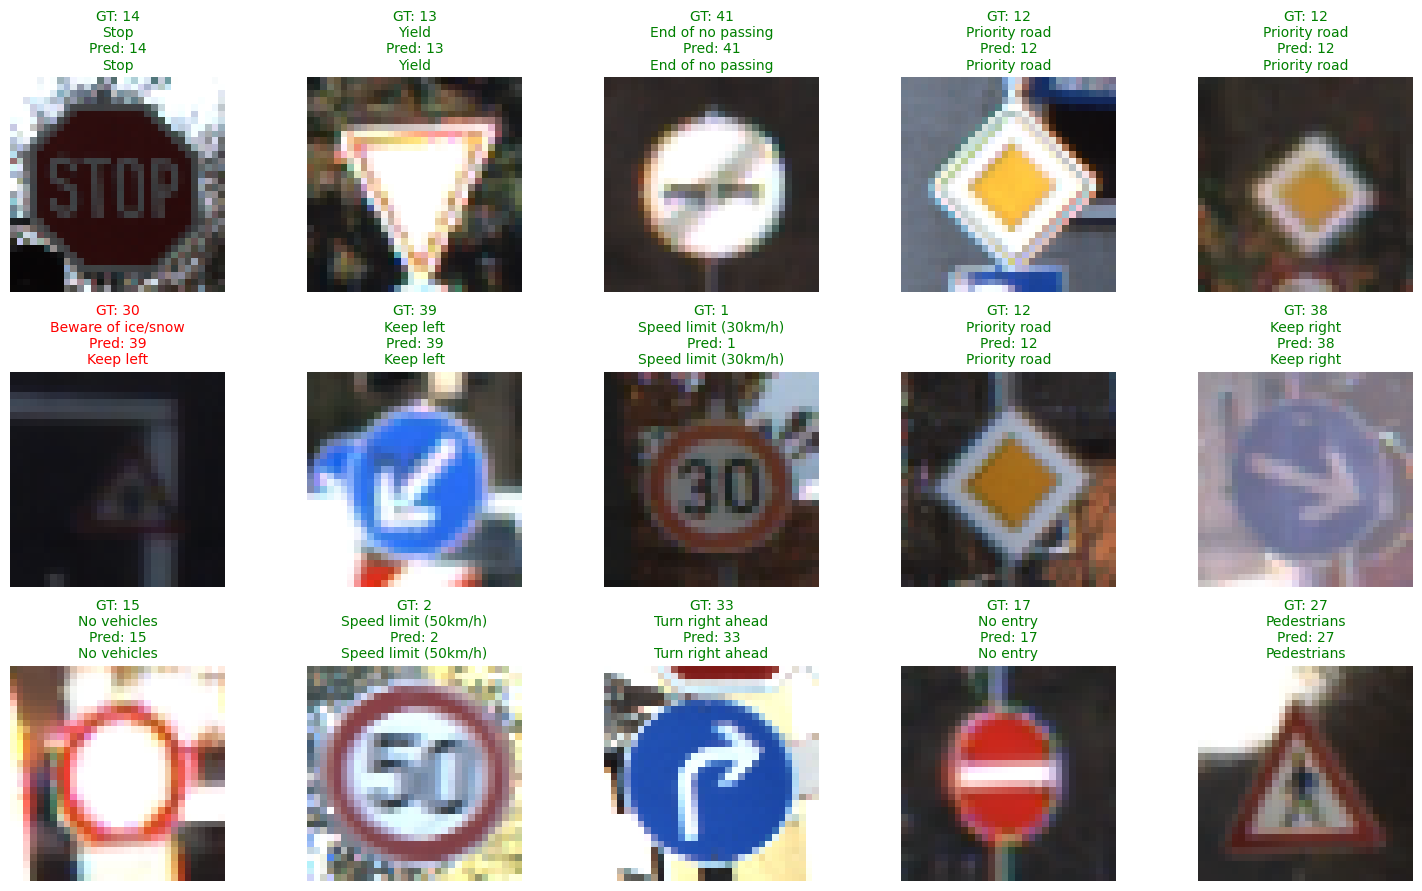

In [11]:
# Visualize Random Test Samples with Predictions
num_samples_to_show = 15
indices = np.random.choice(len(X_test), size=num_samples_to_show, replace=False)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
    img = X_test[idx]
    true_label = y_test[idx]
    pred_label = hybrid_test_pred[idx]
    true_sign_name = sign_mapping.get(true_label, 'Unknown')
    pred_sign_name = sign_mapping.get(pred_label, 'Unknown')
    
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
        
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"GT: {true_label}\n{true_sign_name}\nPred: {pred_label}\n{pred_sign_name}", 
                 fontsize=10,
                 color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 12. Class-wise Accuracy Analysis

Analyze prediction accuracy by class to identify strengths and weaknesses.

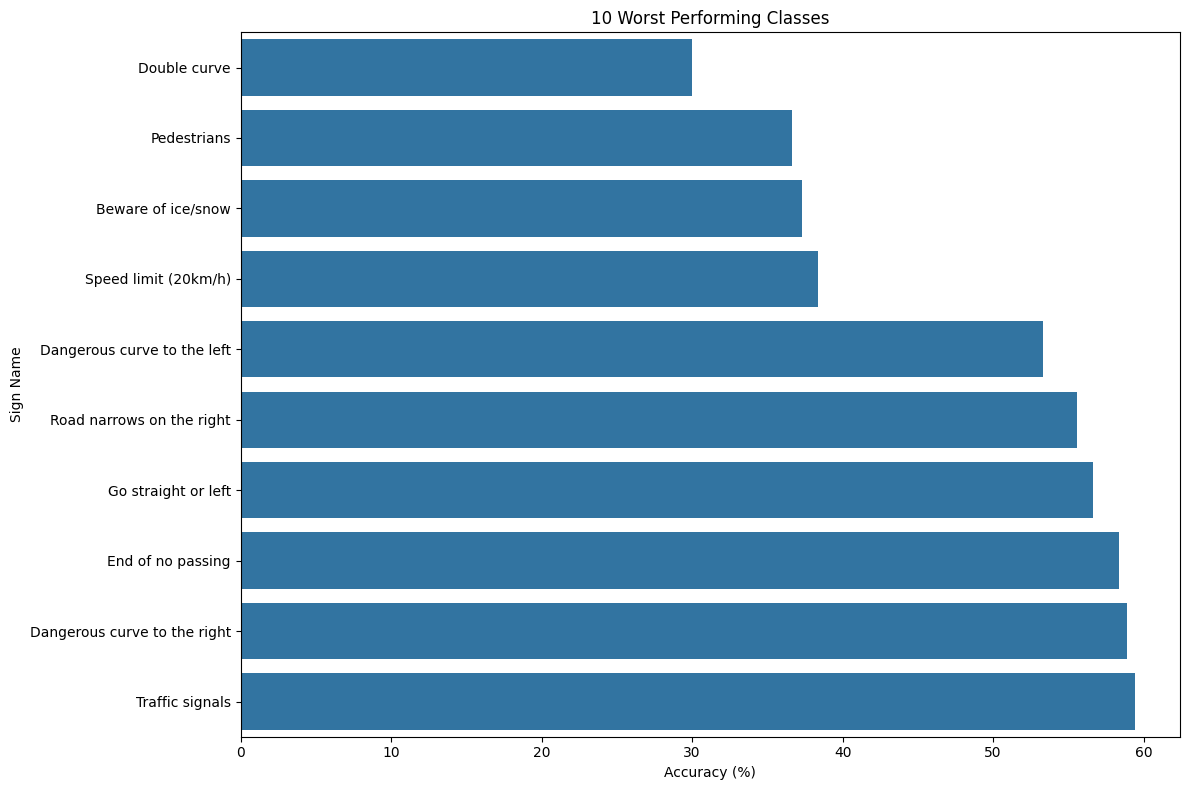

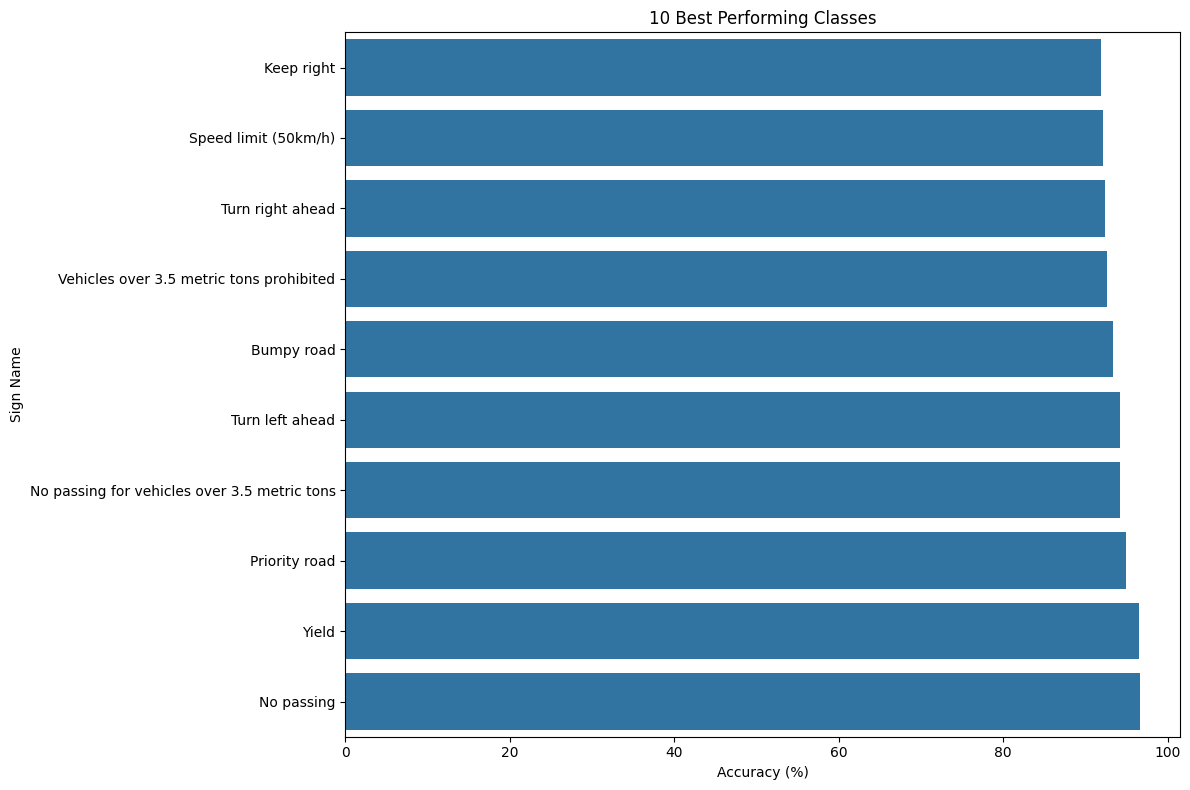

,Class ID,Sign Name,Accuracy (%),Sample Count
9,9,No passing,96.666667,480
13,13,Yield,96.527778,720
12,12,Priority road,94.927536,690
10,10,No passing for vehicles over 3.5 metric tons,94.242424,660
34,34,Turn left ahead,94.166667,120
22,22,Bumpy road,93.333333,120
16,16,Vehicles over 3.5 metric tons prohibited,92.666667,150
33,33,Turn right ahead,92.380952,210
2,2,Speed limit (50km/h),92.133333,750
38,38,Keep right,91.884058,690


In [12]:
# Calculate per-class accuracy
class_accuracy = hybrid_cm.diagonal() / hybrid_cm.sum(axis=1) * 100

# Create a DataFrame for better visualization
class_df = pd.DataFrame({
    'Class ID': list(range(num_classes)),
    'Sign Name': [sign_mapping.get(i, 'Unknown') for i in range(num_classes)],
    'Accuracy (%)': class_accuracy,
    'Sample Count': hybrid_cm.sum(axis=1)
})

# Sort by accuracy
class_df_sorted = class_df.sort_values('Accuracy (%)')

# Plot the 10 worst-performing classes
plt.figure(figsize=(12, 8))
worst_classes = class_df_sorted.head(10)
sns.barplot(x='Accuracy (%)', y='Sign Name', data=worst_classes)
plt.title('10 Worst Performing Classes')
plt.tight_layout()
plt.show()

# Plot the 10 best-performing classes
plt.figure(figsize=(12, 8))
best_classes = class_df_sorted.tail(10)
sns.barplot(x='Accuracy (%)', y='Sign Name', data=best_classes)
plt.title('10 Best Performing Classes')
plt.tight_layout()
plt.show()

# Show the full class-wise accuracy table
class_df.sort_values('Accuracy (%)', ascending=False)

## 13. Conclusion

The hybrid CNN-Tsetlin Machine approach combines the feature extraction capabilities of CNNs with the interpretability and efficiency of Tsetlin Machines.

Key advantages of this approach:
1. Maintains the adaptive Gaussian thresholding preprocessing
2. Uses a simplified CNN architecture for efficient feature extraction
3. Leverages Tsetlin Machine's strengths for the final classification
4. Potentially achieves higher accuracy than either approach alone